In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
import seaborn as sns

# Data loading

In [5]:
#https://www.kaggle.com/datasets/adaoduque/campeonato-brasileiro-de-futebol
url = 'https://raw.githubusercontent.com/adaoduque/Brasileirao_Dataset/master/campeonato-brasileiro-full.csv'
dataset = pd.read_csv(url)
print(dataset.shape)
dataset.info()


(8025, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8025 entries, 0 to 8024
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  8025 non-null   int64 
 1   rodata              8025 non-null   int64 
 2   data                8025 non-null   object
 3   hora                8025 non-null   object
 4   mandante            8025 non-null   object
 5   visitante           8025 non-null   object
 6   formacao_mandante   3051 non-null   object
 7   formacao_visitante  3051 non-null   object
 8   tecnico_mandante    3415 non-null   object
 9   tecnico_visitante   3415 non-null   object
 10  vencedor            8025 non-null   object
 11  arena               8025 non-null   object
 12  mandante_Placar     8025 non-null   int64 
 13  visitante_Placar    8025 non-null   int64 
 14  mandante_Estado     8025 non-null   object
 15  visitante_Estado    8025 non-null   object
dtypes: int64(4), 

# Data pre processing

In [6]:
dataset = dataset.drop(columns=['formacao_mandante','formacao_visitante','tecnico_mandante','tecnico_visitante','rodata'])

In [7]:
dataset['data'] = dataset['data'].apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y',errors='ignore'))

In [8]:
dataset['ano'] = dataset["data"].dt.year

# Ajustar o valor do campo "ano" para jogos no intervalo específico de datas por conta da pandemia
mask = (dataset["data"] > "2021-01-01") & (dataset["data"] < "2021-02-26")
dataset.loc[mask, "ano"] = 2020

In [9]:
coordenadas_estados = {
    'AC': (-9.9746, -67.8074),    # Rio Branco, Acre
    'AL': (-9.6498, -35.7089),    # Maceió, Alagoas
    'AP': (0.0356, -51.0600),     # Macapá, Amapá
    'AM': (-3.4653, -62.2159),    # Manaus, Amazonas
    'BA': (-12.9716, -38.5014),   # Salvador, Bahia
    'CE': (-3.7172, -38.5433),    # Fortaleza, Ceará
    'DF': (-15.7801, -47.9292),   # Brasília, Distrito Federal
    'ES': (-20.3155, -40.3128),   # Vitória, Espírito Santo
    'GO': (-16.6799, -49.2550),   # Goiânia, Goiás
    'MA': (-2.5387, -44.2827),    # São Luís, Maranhão
    'MT': (-15.5989, -56.0949),   # Cuiabá, Mato Grosso
    'MS': (-20.4646, -54.6156),   # Campo Grande, Mato Grosso do Sul
    'MG': (-19.9025, -43.9369),   # Belo Horizonte, Minas Gerais
    'PA': (-1.4550, -48.4898),    # Belém, Pará
    'PB': (-7.1151, -34.8641),    # João Pessoa, Paraíba
    'PR': (-25.4195, -49.2646),   # Curitiba, Paraná
    'PE': (-8.0476, -34.8770),    # Recife, Pernambuco
    'PI': (-5.0939, -42.8010),    # Teresina, Piauí
    'RJ': (-22.9083, -43.1964),   # Rio de Janeiro, Rio de Janeiro
    'RN': (-5.7945, -35.2110),    # Natal, Rio Grande do Norte
    'RS': (-30.0330, -51.2210),   # Porto Alegre, Rio Grande do Sul
    'RO': (-8.7602, -63.8999),    # Porto Velho, Rondônia
    'RR': (2.8199, -60.6715),     # Boa Vista, Roraima
    'SC': (-27.5954, -48.5480),   # Florianópolis, Santa Catarina
    'SP': (-23.5505, -46.6333),   # São Paulo, São Paulo
    'SE': (-10.9472, -37.0731),   # Aracaju, Sergipe
    'TO': (-10.1677, -48.3317)    # Palmas, Tocantins
}
#Fórmula de Haversine para calcular a distância entre as coordenadas geográficas em 
# um sistema de coordenadas esférico (latitude e longitude)
def calcular_distancia(coord1, coord2):
    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Raio da Terra em km (aproximadamente)
    raio_terra = 6371.0
    
    distancia = raio_terra * c
    return distancia

# Adicione uma nova coluna 'distancia_percorrida' ao DataFrame
dataset['distancia_percorrida'] = dataset.apply(lambda row: calcular_distancia(
    coordenadas_estados.get(row['mandante_Estado'], (0, 0)),  # Coord. do mandante
    coordenadas_estados.get(row['visitante_Estado'], (0, 0))  # Coord. do visitante
), axis=1)

In [10]:
# Crie um dicionário de DataFrames separados por ano
dataframes_por_ano = {}
for ano, grupo in dataset.groupby('ano'):
    dataframes_por_ano[ano] = grupo

In [11]:
import pandas as pd

# Suponha que 'dataset' seja o DataFrame original com colunas como 'ano', 'mandante', 'visitante', 'vencedor', 'distancia_percorrida', etc.

# Crie um dicionário para armazenar os pontos dos times por ano e a distância percorrida
pontos_por_time = {'ano': [], 'time': [], 'pontos': [], 'distancia_percorrida': []}

# Loop pelos anos únicos no DataFrame
for ano in dataset['ano'].unique():
    ano_df = dataset[dataset['ano'] == ano]
    
    # Inicialize um dicionário para rastrear os pontos de cada time e a distância percorrida
    pontos = {}
    distancia_percorrida = {}
    
    # Loop pelas linhas do DataFrame para atribuir os pontos e a distância percorrida
    for index, row in ano_df.iterrows():
        mandante = row['mandante']
        visitante = row['visitante']
        
        # Verifique se a distância percorrida é um valor numérico
        if pd.notna(row['distancia_percorrida']) and isinstance(row['distancia_percorrida'], (int, float)):
            # Adicione a distância percorrida ao dicionário
            distancia_percorrida[mandante] = row['distancia_percorrida']
            distancia_percorrida[visitante] = row['distancia_percorrida']
        
        # Se o time mandante ganhar, atribua 3 pontos ao mandante
        # Se o time visitante ganhar, atribua 3 pontos ao visitante
        # Em caso de empate, atribua 1 ponto a cada time
        if mandante == visitante:
            pontos[mandante] = pontos.get(mandante, 0) + 1
            pontos[visitante] = pontos.get(visitante, 0) + 1
        else:
            pontos[row['vencedor']] = pontos.get(row['vencedor'], 0) + 3
    
    # Adicione os pontos e a distância percorrida de cada time ao dicionário final
    for time, pontos_time in pontos.items():
        pontos_por_time['ano'].append(ano)
        pontos_por_time['time'].append(time)
        pontos_por_time['pontos'].append(pontos_time)
        # Verifique se a distância percorrida está disponível antes de adicioná-la
        pontos_por_time['distancia_percorrida'].append(distancia_percorrida.get(time, None))

# Crie um DataFrame com os pontos dos times, a distância percorrida e o ano
pontos_df = pd.DataFrame(pontos_por_time)

pontos_df = pontos_df.sort_values(by=['ano', 'pontos'], ascending=[True, False])

# Exiba o DataFrame com os pontos dos times, a distância percorrida e o ano
print(pontos_df)

      ano         time  pontos  distancia_percorrida
2    2003            -     426                   NaN
12   2003     Cruzeiro      93            964.086408
15   2003       Santos      75            358.360612
20   2003    Sao Paulo      66            358.360612
22   2003     Coritiba      63            252.235552
..    ...          ...     ...                   ...
414  2022       Cuiaba      30           1302.557754
415  2022         Avai      27            748.991953
428  2022  Atletico-GO      24            665.971466
410  2022        Ceara      21           3215.675619
427  2022    Juventude       9           3215.675619

[430 rows x 4 columns]


In [18]:
# Filtrar os times com "-"
pontos_df = pontos_df[pontos_df['time'] != '-']

# Criar uma lista para armazenar os três primeiros de cada ano
top_tres_por_ano = []

# Loop pelos anos únicos no DataFrame
for ano in pontos_df['ano'].unique():
    ano_df = pontos_df[pontos_df['ano'] == ano]
    
    # Ordenar por pontos em ordem decrescente
    ano_df = ano_df.sort_values(by='pontos', ascending=False)
    
    # Pegar os três primeiros times do ano, excluindo "-" e times repetidos
    top_tres_do_ano = ano_df.head(5)
    
    top_tres_por_ano.append(top_tres_do_ano)

# Exibir os três primeiros de cada ano com o maior número de pontos
for df in top_tres_por_ano:
    print(df[['ano', 'time', 'pontos','distancia_percorrida']])

     ano           time  pontos  distancia_percorrida
12  2003       Cruzeiro      93            964.086408
15  2003         Santos      75            358.360612
20  2003      Sao Paulo      66            358.360612
22  2003       Coritiba      63            252.235552
5   2003  Internacional      60            852.366691
     ano          time  pontos  distancia_percorrida
38  2004        Santos      81            358.360612
39  2004  Athletico-PR      75            675.880482
34  2004     Sao Paulo      72            811.457965
27  2004   Sao Caetano      69            492.015843
43  2004     Palmeiras      66            358.360612
     ano           time  pontos  distancia_percorrida
67  2005    Corinthians      72            811.457965
62  2005  Internacional      69            547.914316
50  2005          Goias      66            811.457965
58  2005      Palmeiras      60            358.360612
55  2005     Fluminense      57            358.360612
     ano           time  pontos  d

# Data Analysis

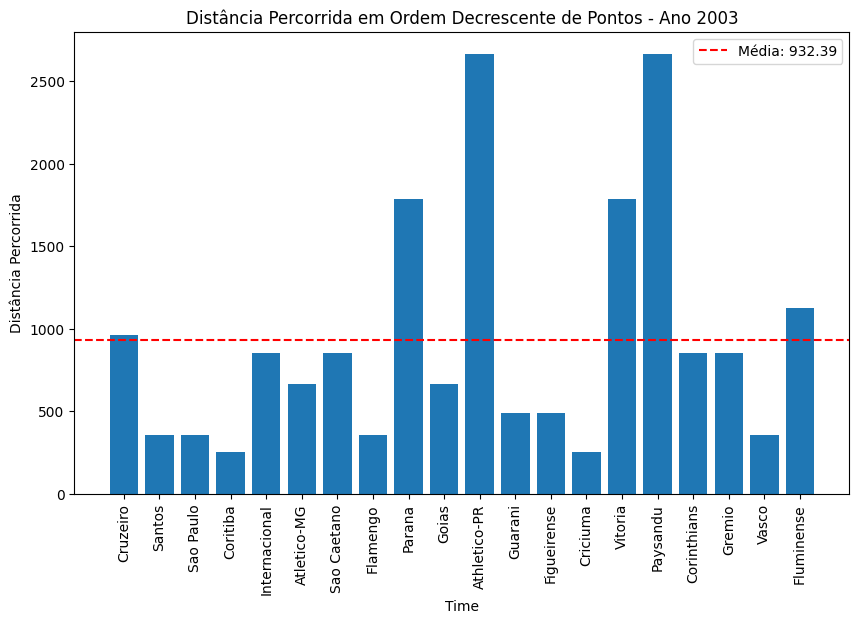

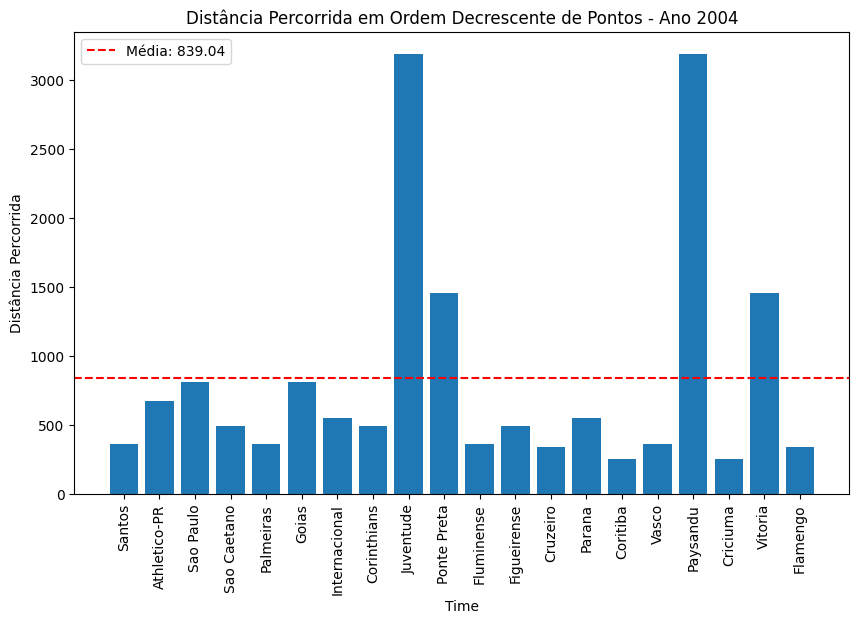

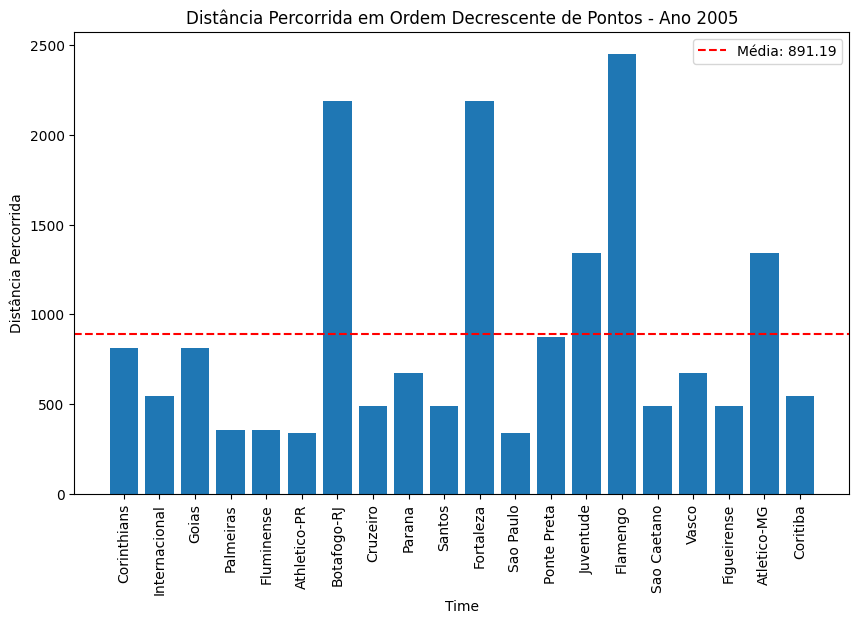

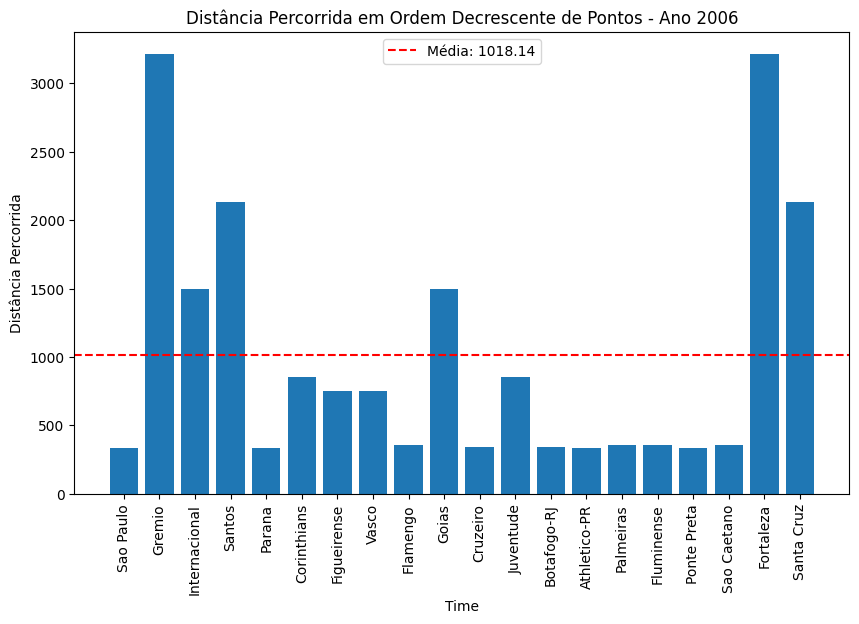

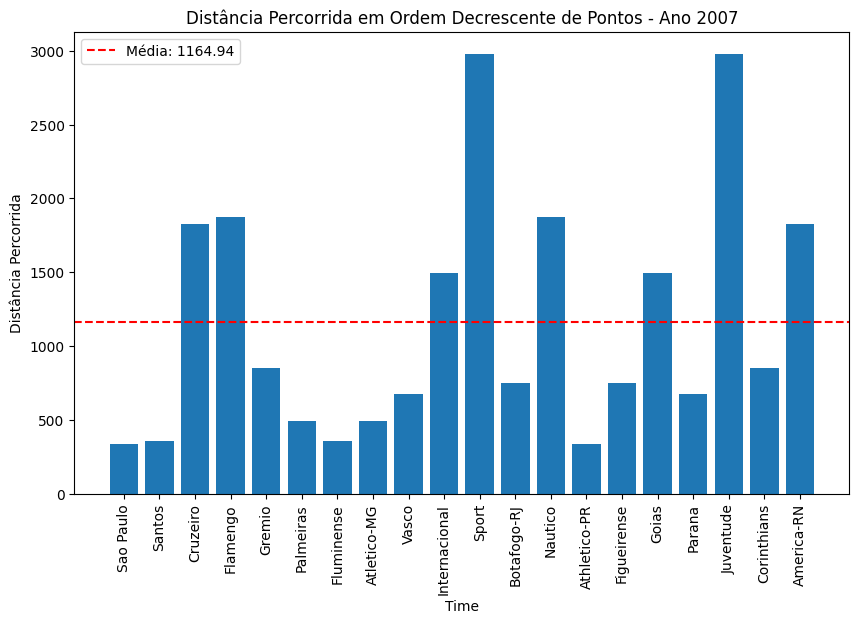

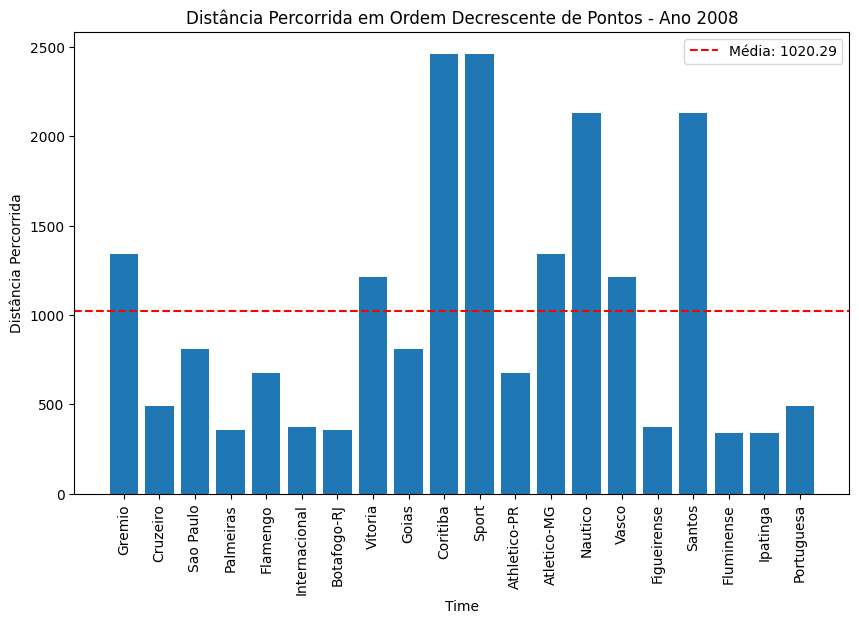

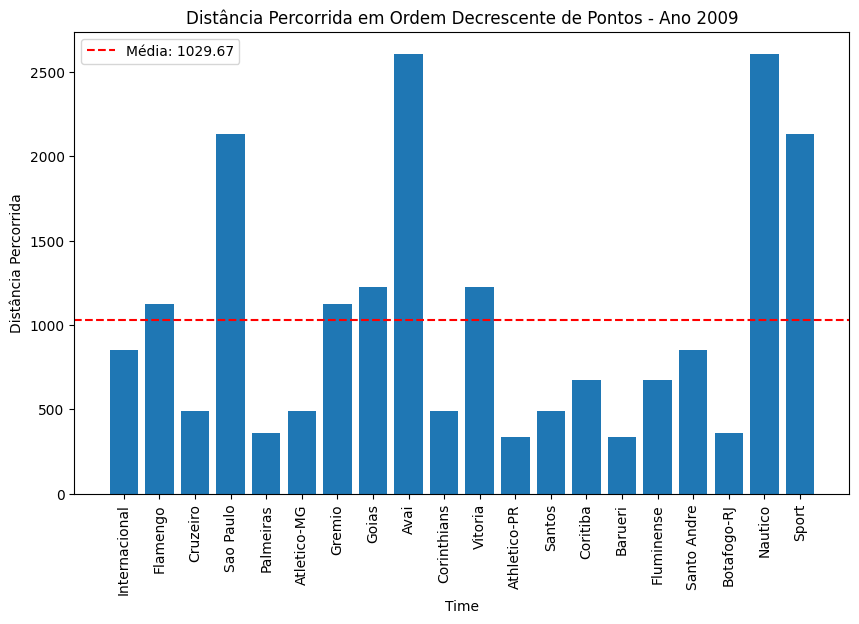

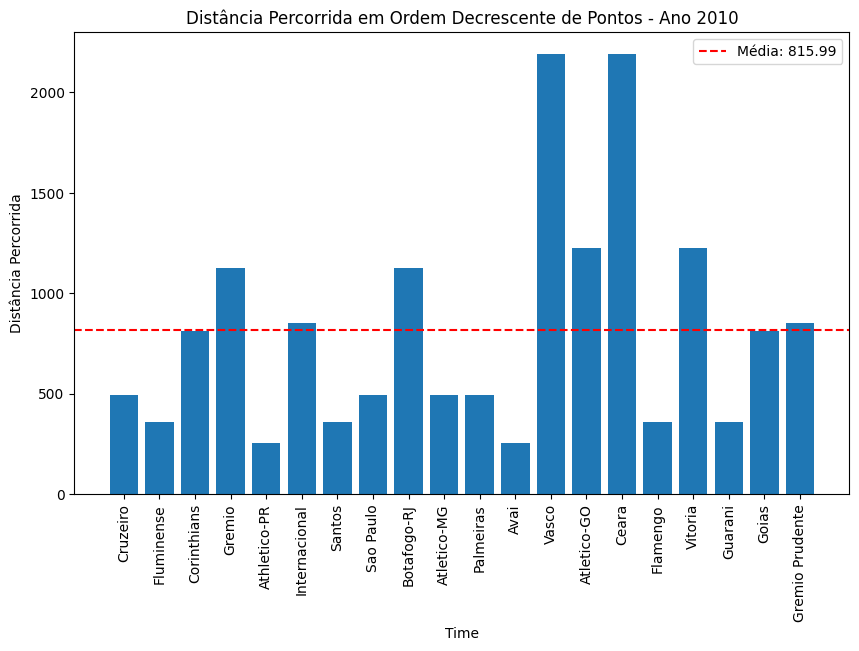

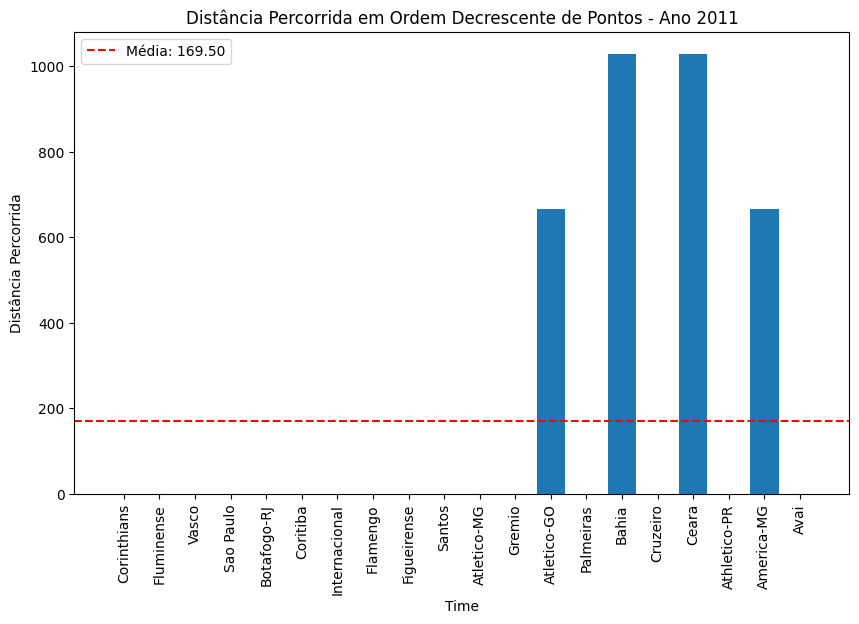

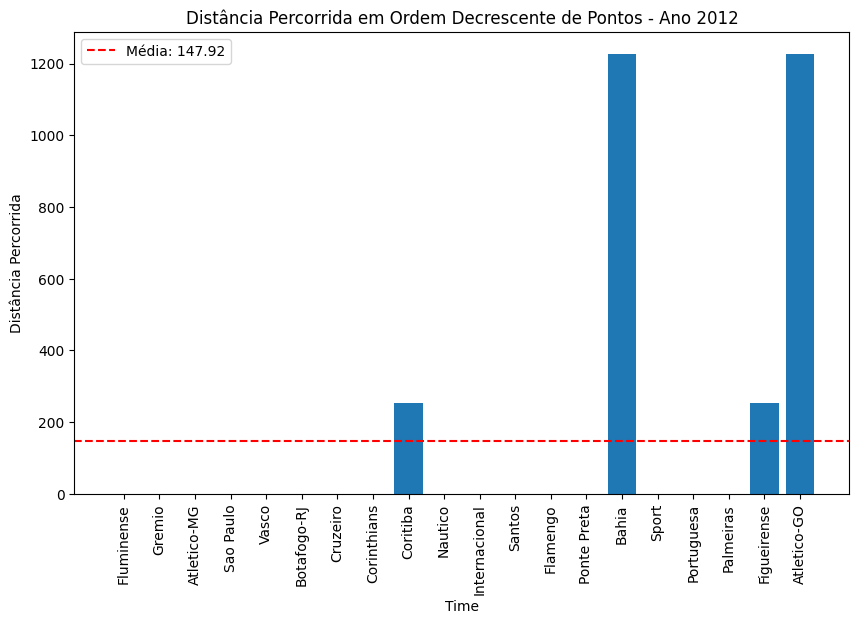

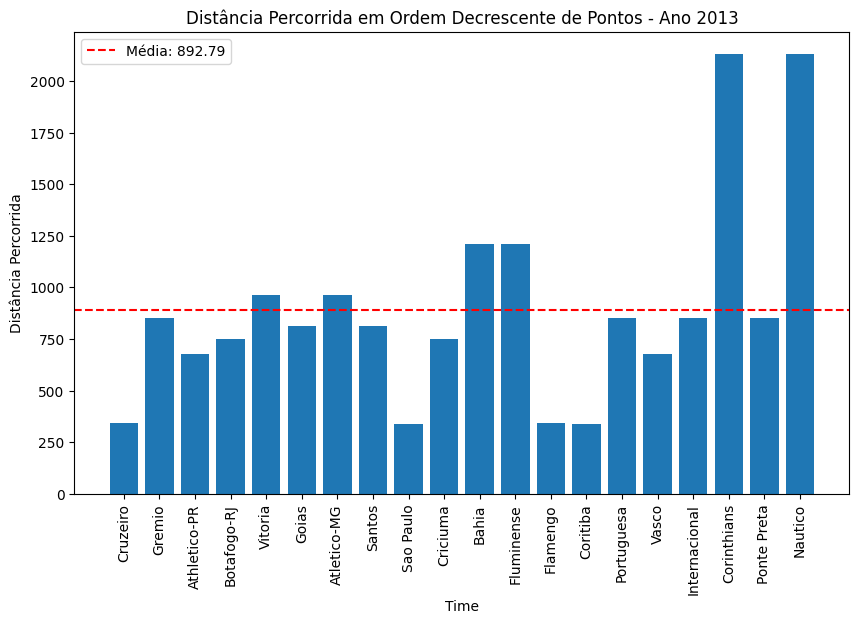

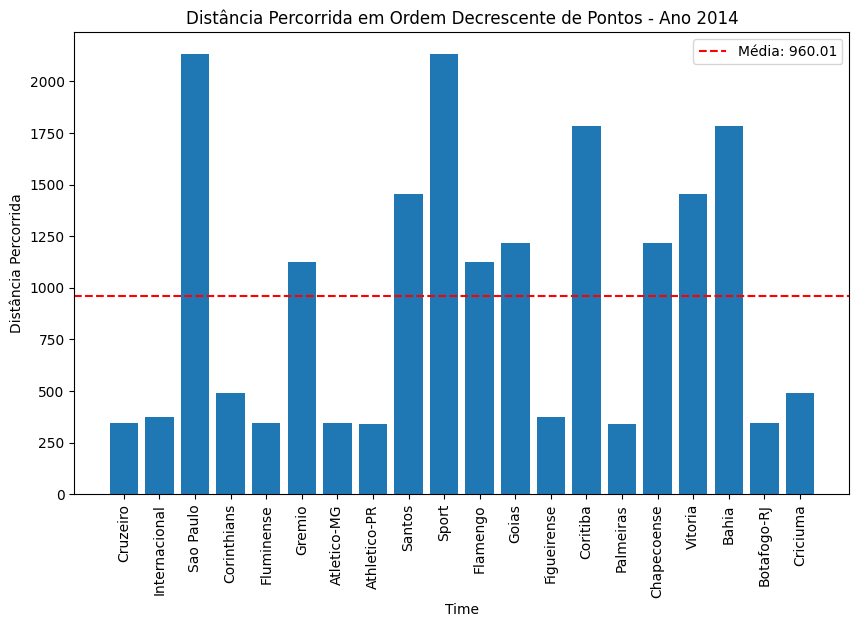

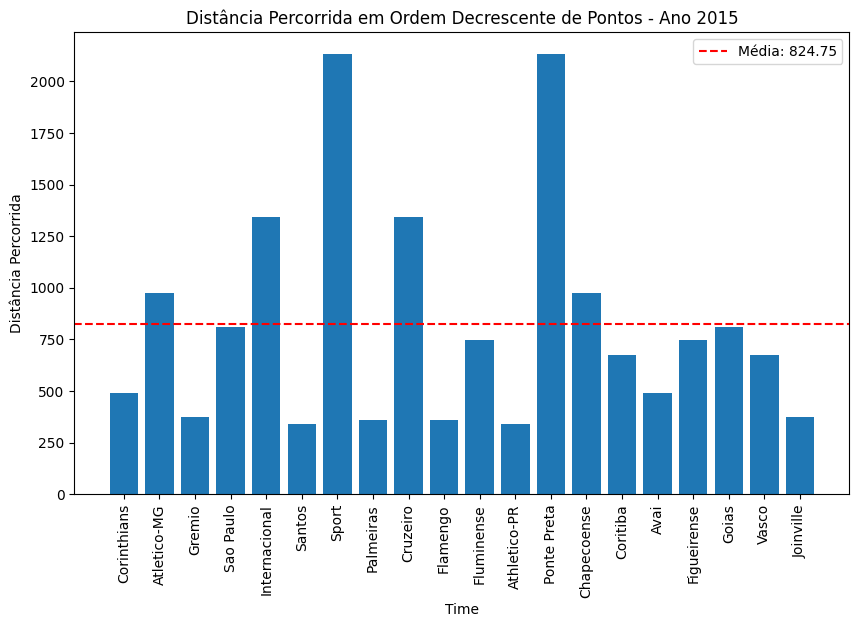

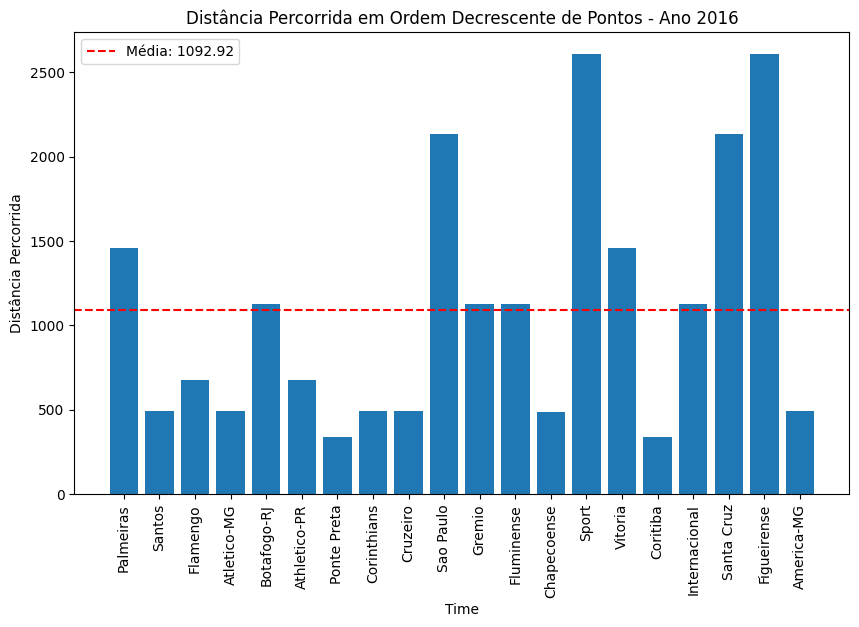

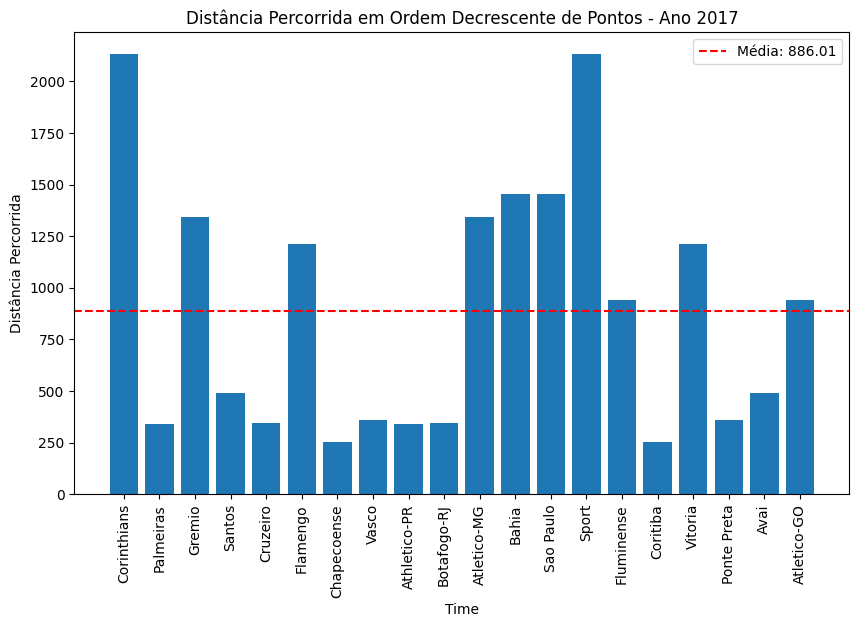

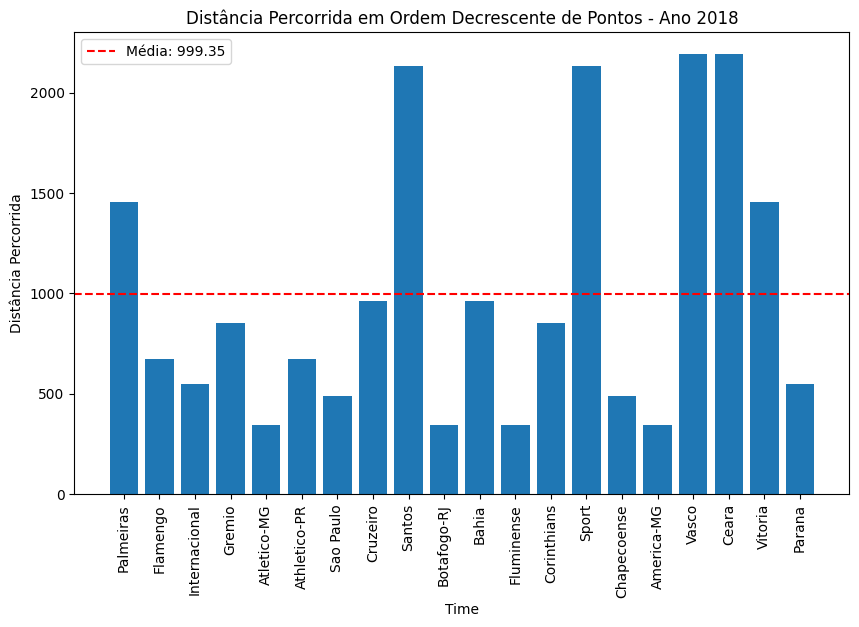

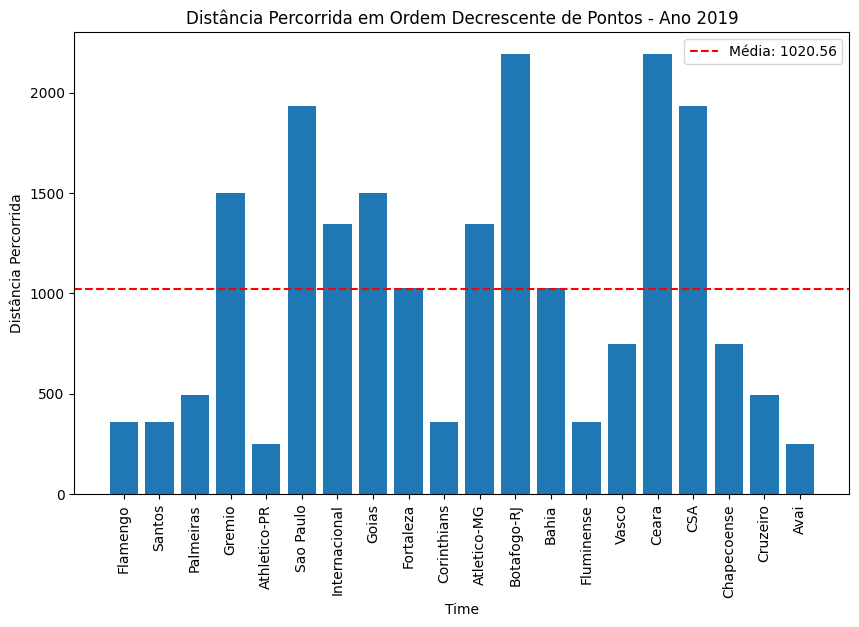

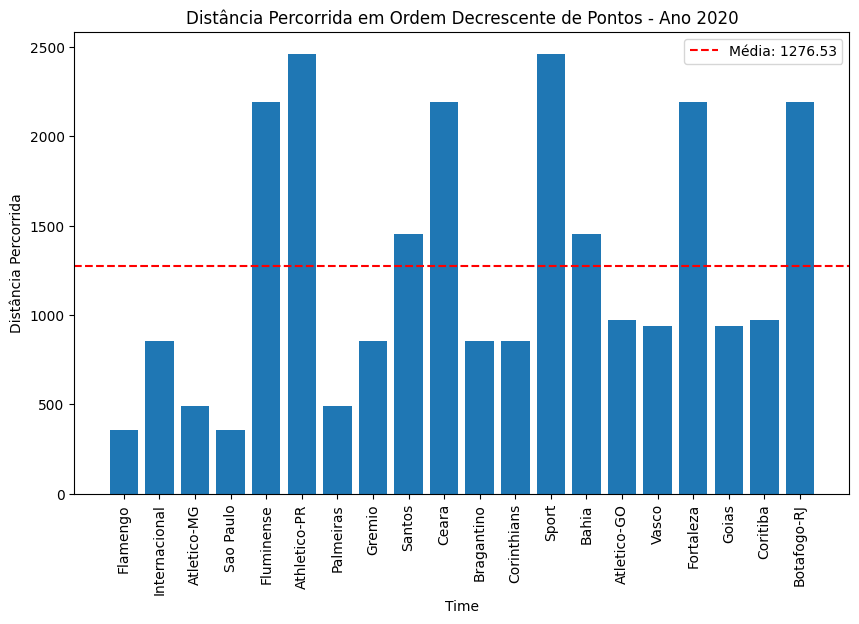

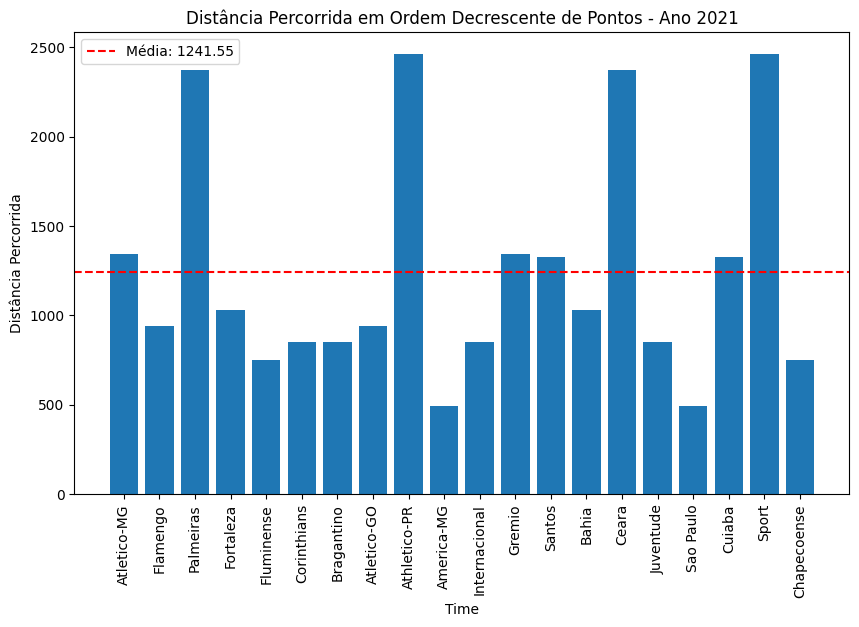

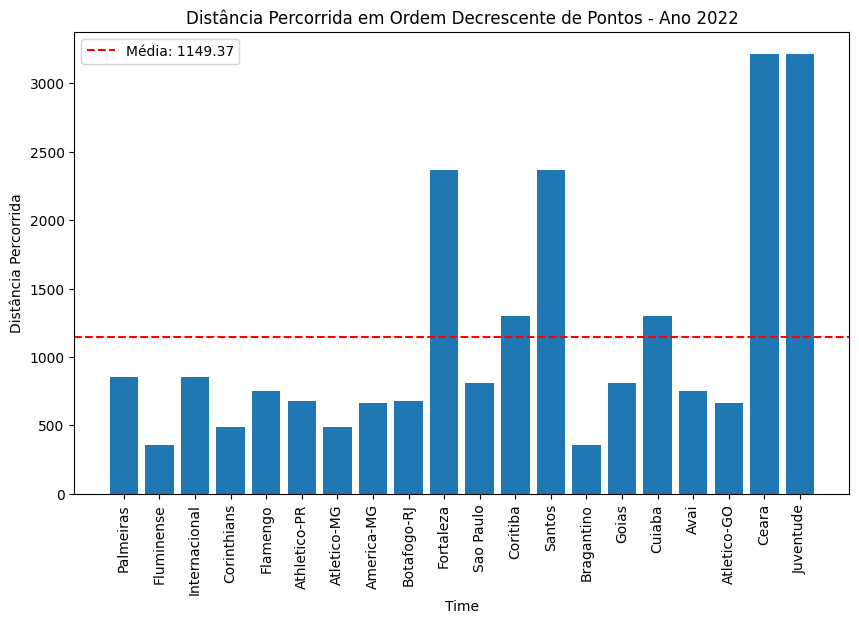

In [29]:
import matplotlib.pyplot as plt

# Filtrar os times com "-"
pontos_df = pontos_df[pontos_df['time'] != '-']

# Criar uma lista para armazenar os três primeiros de cada ano
top_tres_por_ano = []

# Loop pelos anos únicos no DataFrame
for ano in pontos_df['ano'].unique():
    ano_df = pontos_df[pontos_df['ano'] == ano]
    
    # Ordenar por pontos em ordem decrescente
    ano_df = ano_df.sort_values(by='pontos', ascending=False)
    
    # Pegar os três primeiros times do ano, excluindo "-" e times repetidos
    top_tres_do_ano = ano_df.head(20)
    
    top_tres_por_ano.append(top_tres_do_ano)

# Exibir gráficos separados para cada ano
for i, df in enumerate(top_tres_por_ano):
    df = df.sort_values(by='pontos', ascending=False)
    
    # Calcular a média da distância percorrida
    media_distancia = df['distancia_percorrida'].mean()
    
    plt.figure(figsize=(10, 6))
    plt.bar(df['time'], df['distancia_percorrida'])
    
    # Adicionar a linha da média
    plt.axhline(y=media_distancia, color='r', linestyle='--', label=f'Média: {media_distancia:.2f}')
    
    plt.title(f'Distância Percorrida em Ordem Decrescente de Pontos - Ano {df.iloc[0]["ano"]}')
    plt.xlabel('Time')
    plt.ylabel('Distância Percorrida')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suponha que 'pontos_df' seja o DataFrame resultante com as informações de pontos e distância percorrida

# Configuração do estilo do gráfico
sns.set(style="whitegrid")

# Crie um gráfico de dispersão
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(x='pontos', y='distancia_percorrida', hue='time', data=pontos_df, s=100)

# Adicione rótulos aos pontos
for line in range(0, pontos_df.shape[0]):
    scatter_plot.text(pontos_df['pontos'][line]+0.2, pontos_df['distancia_percorrida'][line],
                      pontos_df['time'][line], horizontalalignment='left', size='medium', color='black', weight='semibold')

# Adicione rótulos e título
plt.title('Pontos vs. Distância Percorrida por Time')
plt.xlabel('Pontos')
plt.ylabel('Distância Percorrida')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Exiba o gráfico
plt.show()

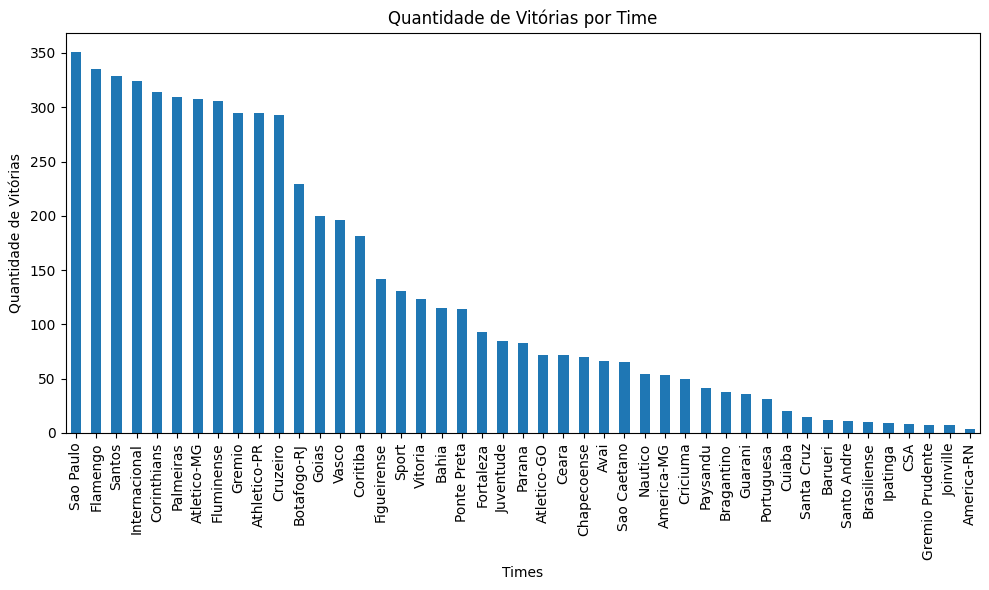

In [12]:
# Contagem de vitórias por time
vitorias_por_time = dataset[dataset["vencedor"] != "-"]["vencedor"].value_counts()

plt.figure(figsize=(10, 6))

vitorias_por_time.plot(kind="bar")
plt.title("Quantidade de Vitórias por Time")
plt.xlabel("Times")
plt.ylabel("Quantidade de Vitórias")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [13]:
dataset.describe()

,ID,data,mandante_Placar,visitante_Placar,ano,distancia_percorrida
count,8025.000000,8025,8025.000000,8025.000000,8025.000000,8025.000000
mean,4013.000000,2012-09-07 16:43:14.691588864,1.547040,1.024922,2012.037134,935.016265
min,1.000000,2003-03-29 00:00:00,0.000000,0.000000,2003.000000,0.000000
25%,2007.000000,2007-06-17 00:00:00,1.000000,0.000000,2007.000000,358.360612
50%,4013.000000,2012-08-16 00:00:00,1.000000,1.000000,2012.000000,748.991953
75%,6019.000000,2017-10-15 00:00:00,2.000000,2.000000,2017.000000,1343.726300
max,8025.000000,2022-11-13 00:00:00,7.000000,7.000000,2022.000000,3215.675619
std,2316.762288,NaN,1.232277,1.024076,5.944355,760.857999


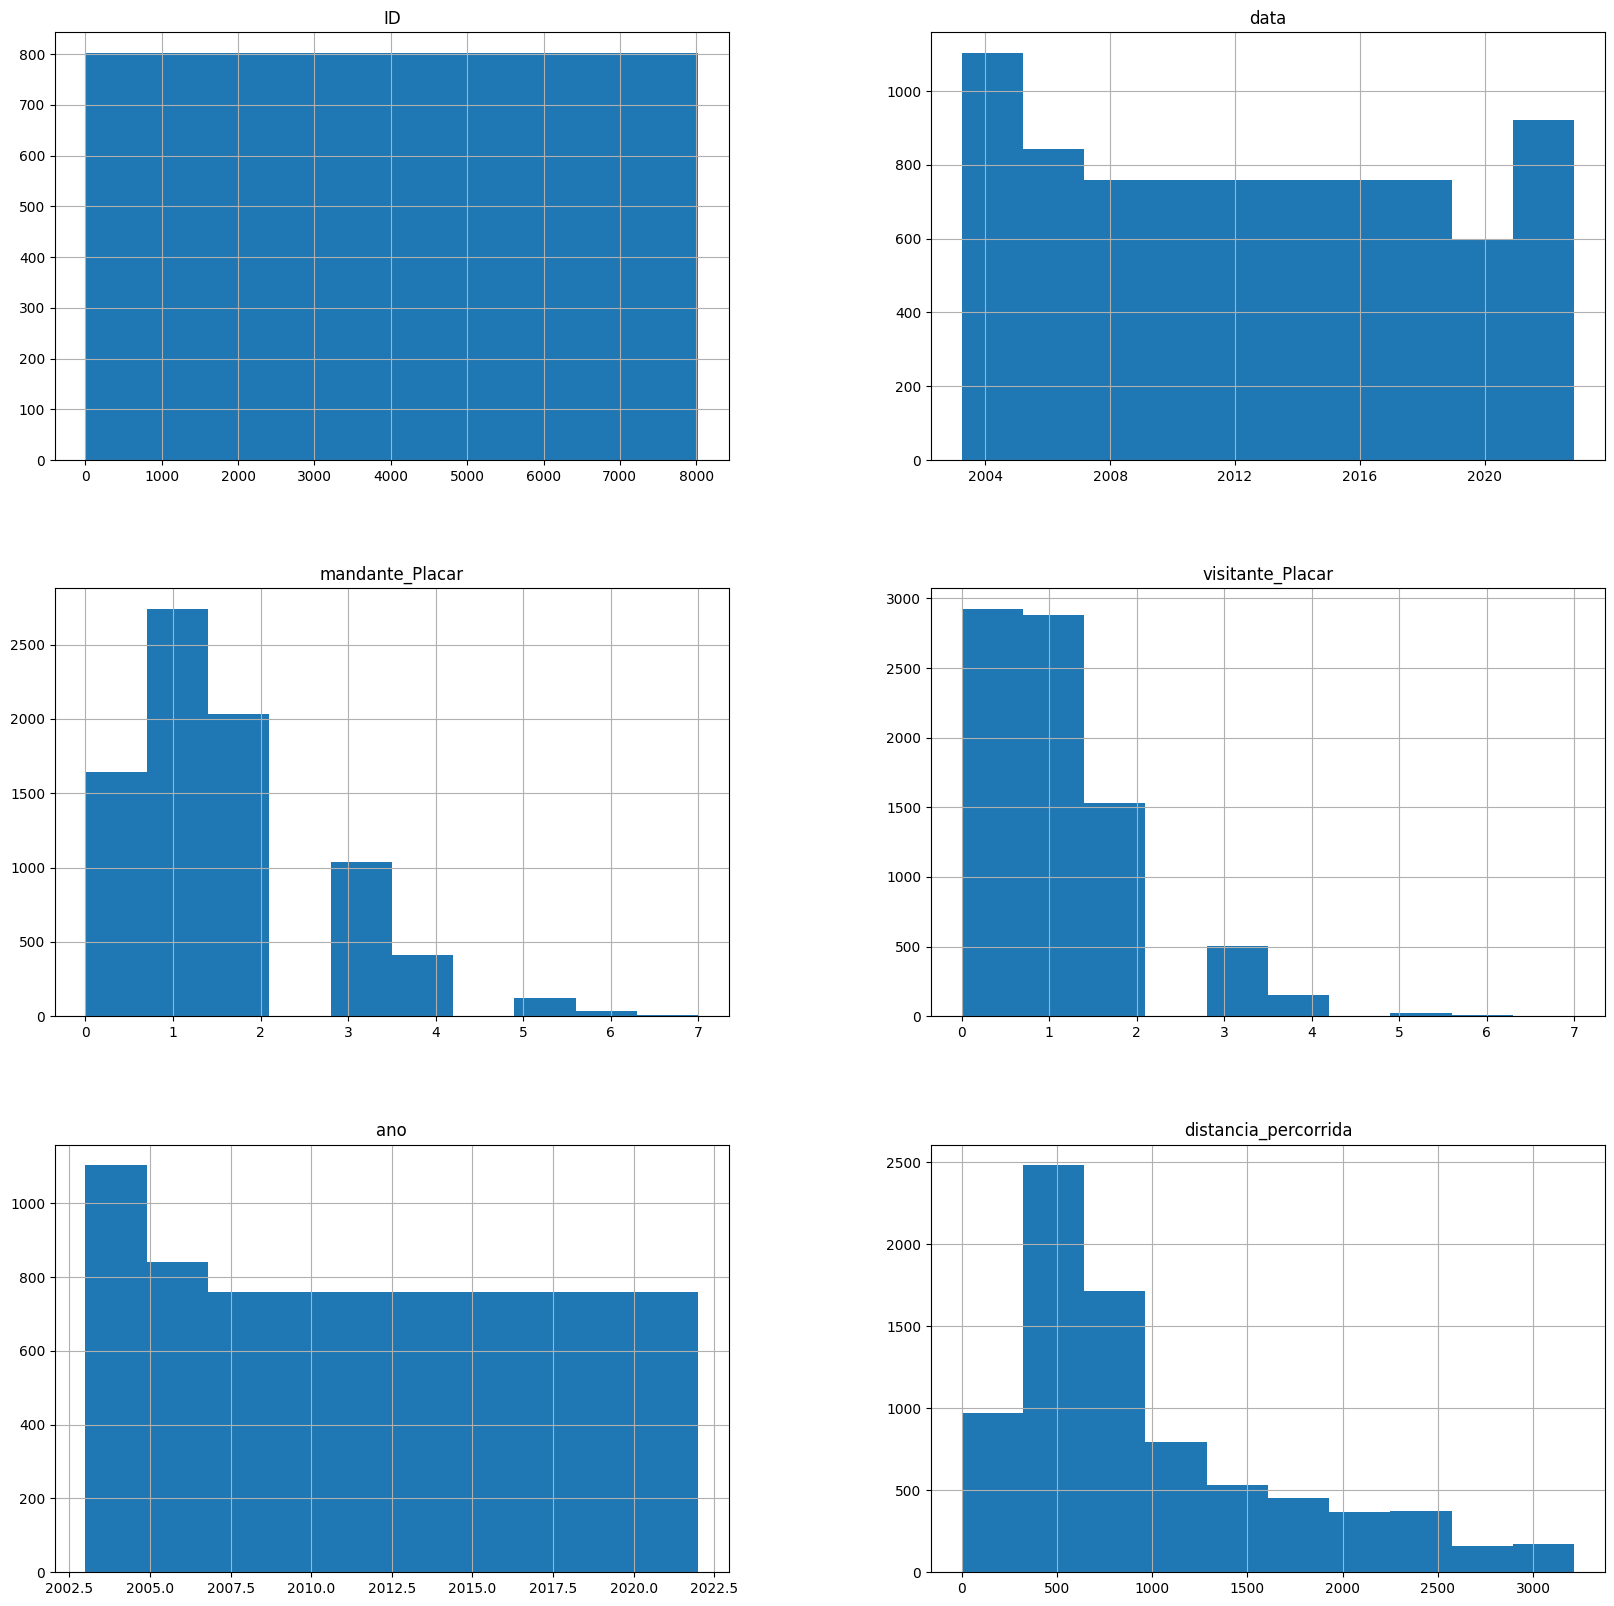

In [14]:
dataset.hist(figsize=(20,20));

<Figure size 3000x1500 with 0 Axes>

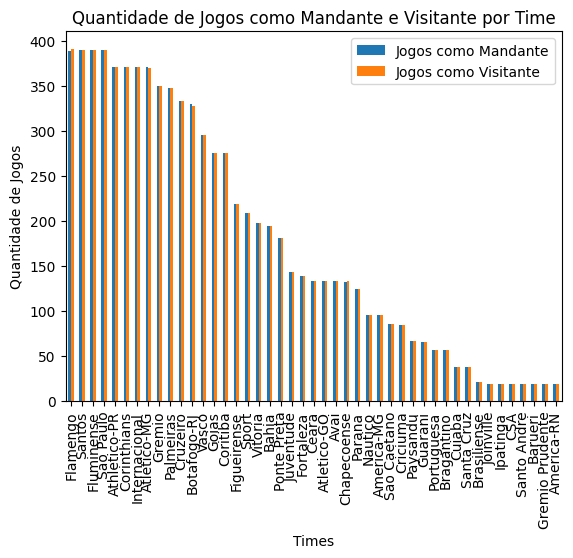

In [15]:
# Contagem de jogos como mandante
mandante_counts = dataset["mandante"].value_counts()

# Contagem de jogos como visitante
visitante_counts = dataset["visitante"].value_counts()

# Combina as contagens em um DataFrame único
total_counts = pd.concat([mandante_counts, visitante_counts], axis=1, sort=True)
total_counts.columns = ["Jogos como Mandante", "Jogos como Visitante"]
total_counts = total_counts.fillna(0)  # Preenche valores nulos com 0

# Ordena o DataFrame pelas contagens totais (soma de jogos como mandante e visitante)
total_counts["Total de Jogos"] = total_counts["Jogos como Mandante"] + total_counts["Jogos como Visitante"]
total_counts = total_counts.sort_values(by="Total de Jogos", ascending=False)

# Plotar o gráfico de barras
plt.figure(figsize=(30, 15))
total_counts.plot(kind="bar", y=["Jogos como Mandante", "Jogos como Visitante"])
plt.title("Quantidade de Jogos como Mandante e Visitante por Time")
plt.xlabel("Times")
plt.ylabel("Quantidade de Jogos")
plt.show()

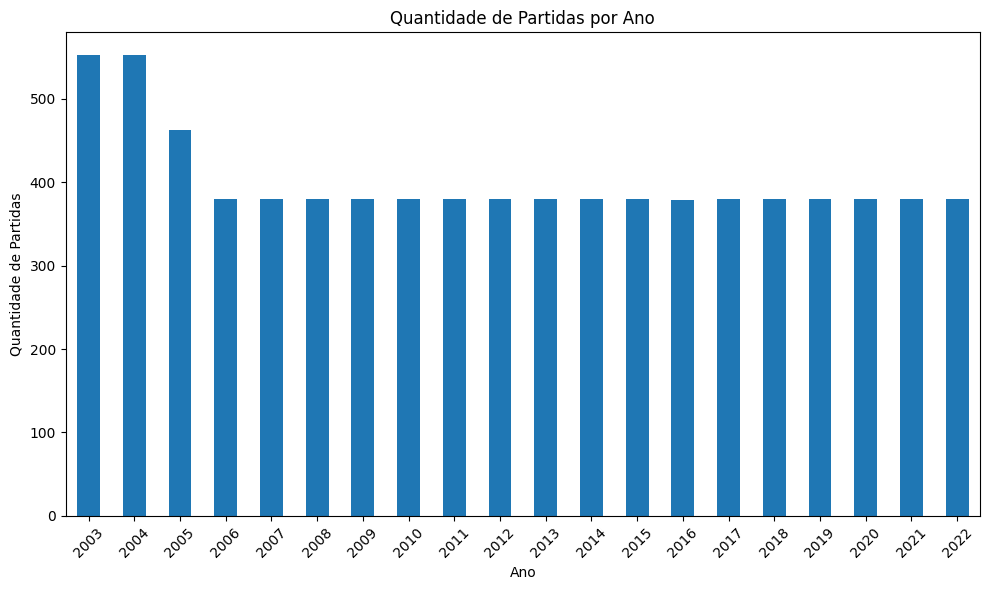

In [16]:
partidas_por_ano = dataset["ano"].value_counts().sort_index()

plt.figure(figsize=(10, 6))

partidas_por_ano.plot(kind="bar")
plt.title("Quantidade de Partidas por Ano")
plt.xlabel("Ano")
plt.ylabel("Quantidade de Partidas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


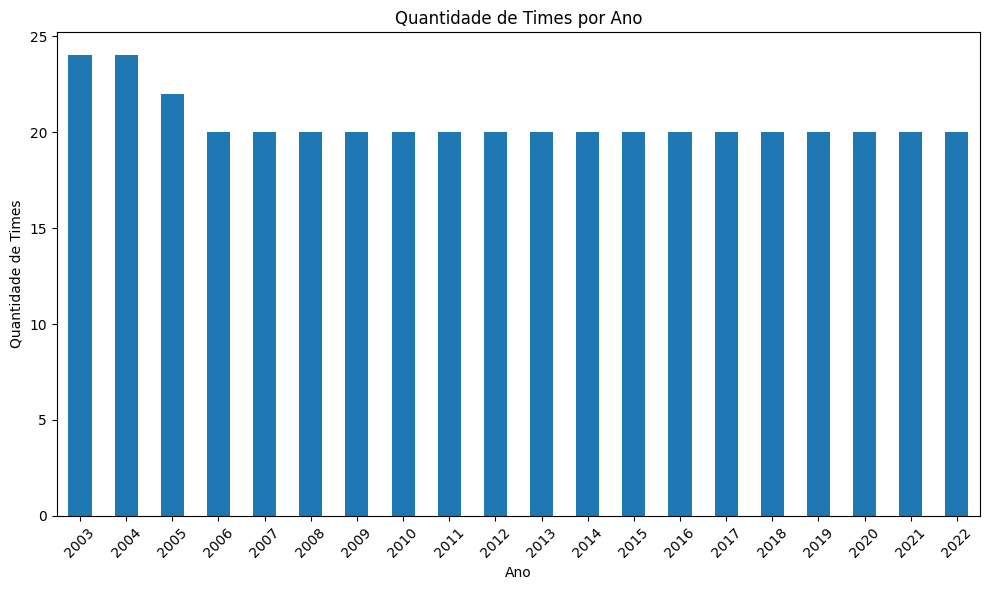

In [17]:
# Contagem de times únicos por ano
times_por_ano = dataset.groupby("ano")["visitante"].nunique()

plt.figure(figsize=(10, 6))

times_por_ano.plot(kind="bar")
plt.title("Quantidade de Times por Ano")
plt.xlabel("Ano")
plt.ylabel("Quantidade de Times")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


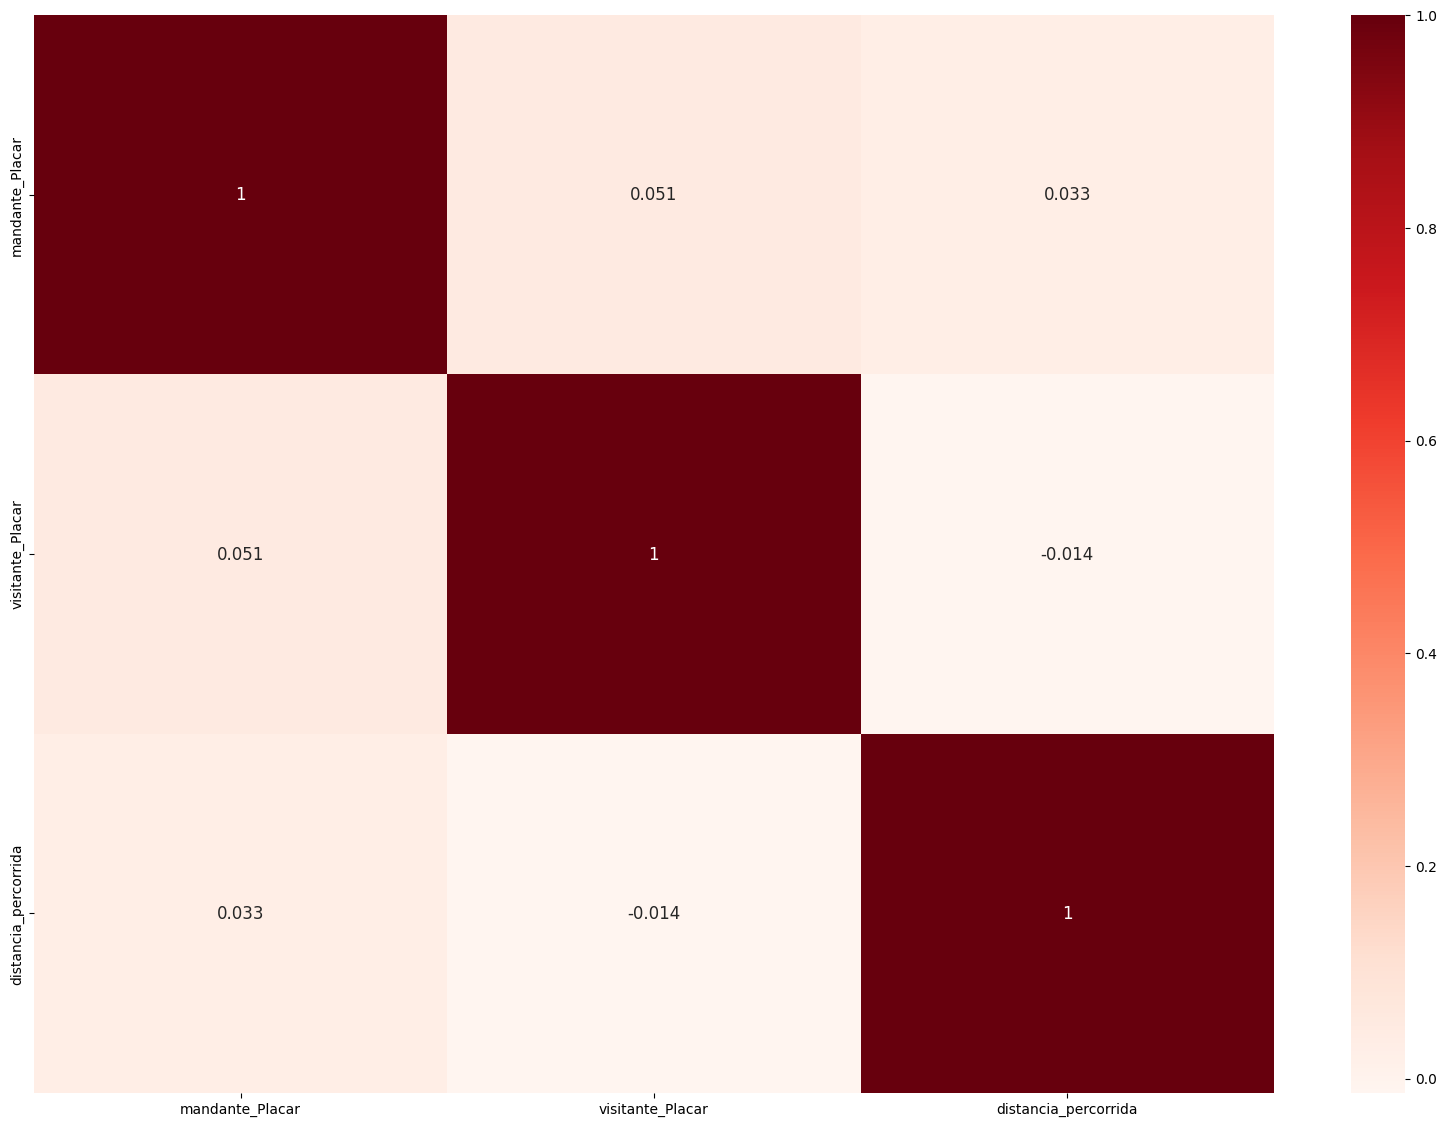

In [18]:
dataset_corr = dataset.reindex(columns=['mandante_Placar', 'visitante_Placar', 'distancia_percorrida'])
plt.figure(figsize=(20, 14))
sns.heatmap(dataset_corr.corr(),annot=True, cmap=plt.cm.Reds,annot_kws={"fontsize":12});
plt.show()

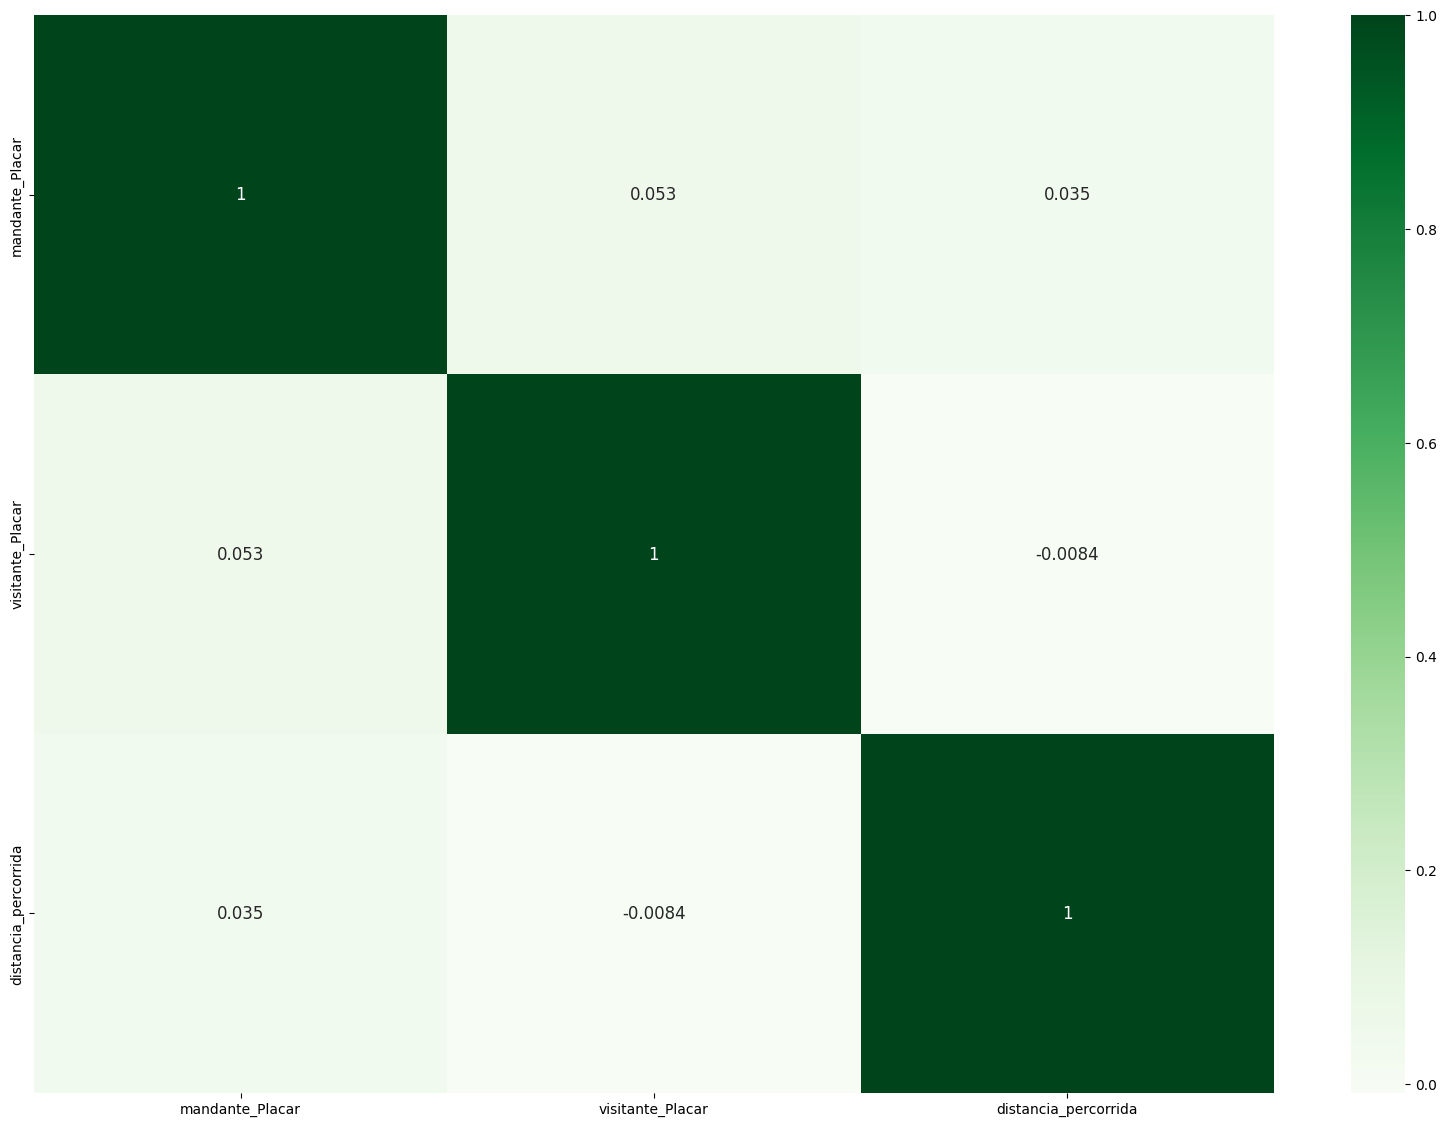

In [19]:
dataset_corr = dataset.reindex(columns=['mandante_Placar', 'visitante_Placar', 'distancia_percorrida'])
plt.figure(figsize=(20, 14))
sns.heatmap(dataset_corr.corr(method='spearman'),annot=True, cmap=plt.cm.Greens,annot_kws={"fontsize":12});
plt.show()

In [20]:
dataset

,ID,data,hora,mandante,visitante,vencedor,arena,mandante_Placar,visitante_Placar,mandante_Estado,visitante_Estado,ano,distancia_percorrida
0,1,2003-03-29,16:00,Guarani,Vasco,Guarani,Brinco de Ouro,4,2,SP,RJ,2003,358.360612
1,2,2003-03-29,16:00,Athletico-PR,Gremio,Athletico-PR,Arena da Baixada,2,0,PR,RS,2003,547.914316
2,3,2003-03-30,16:00,Flamengo,Coritiba,-,Maracanã,1,1,RJ,PR,2003,675.880482
3,4,2003-03-30,16:00,Goias,Paysandu,-,Serra Dourada,2,2,GO,PA,2003,1695.002249
4,5,2003-03-30,16:00,Internacional,Ponte Preta,-,Beira Rio,1,1,RS,SP,2003,852.366691
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8020,8021,2022-11-13,16:03,Cuiaba,Coritiba,Cuiaba,Arena Pantanal,2,1,MT,PR,2022,1302.557754
8021,8022,2022-11-13,16:03,Bragantino,Fluminense,Fluminense,Nabizão,0,1,SP,RJ,2022,358.360612
8022,8023,2022-11-13,16:03,Corinthians,Atletico-MG,Atletico-MG,Neo Química Arena,0,1,SP,MG,2022,492.015843
8023,8024,2022-11-13,16:03,Internacional,Palmeiras,Internacional,Estádio José Pinheiro Borda,3,0,RS,SP,2022,852.366691
